<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/Notebook_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación Comparativa de Modelos de Regresión - Ames Housing

Este notebook maestro consolida y analiza el desempeño de múltiples modelos de regresión aplicados al conjunto de datos **Ames Housing**. A través de métricas clave (MAE, RMSE, R², MAPE) y análisis estadístico, se identifican los tres mejores modelos para su posterior visualización en un dashboard interactivo.

El flujo de trabajo incluye:

- Carga y limpieza de métricas de validación cruzada.
- Análisis de multicolinealidad.
- Comparaciones visuales de desempeño.
- Diagnóstico de residuos.
- Selección final de modelos óptimos.

> Objetivo: seleccionar los 3 modelos con mayor precisión y estabilidad para visualización y despliegue.


In [1]:
# === Clonar repositorio y verificar estructura ===
!rm -rf Teoria-de-Aprendizaje-Maquina  # Eliminar si existe para evitar errores
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git

from pathlib import Path
import pandas as pd
import numpy as np

# Definir ruta base dentro del repo clonado
data_path = Path("Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data")

# Mapear modelo a archivo CSV correspondiente
model_files = {
    "LinearRegression": "resultados_lr_original_scale.csv",
    "Lasso": "resultados_lasso.csv",
    "ElasticNet": "resultados_elasticnet.csv",
    "KernelRidge": "resultados_kernelridge_opt.csv",
    "SGDRegressor": "resultados_sgd_opt.csv",
    "BayesianRidge": "metricas_residuos_folds_bayesianridge.csv",
    "RandomForestRegressor": "rf_validacion_cruzada.csv",
    "GaussianProcess": "resultados_gaussian_process.csv",
    "SVR": "resultados_svr_.csv"
}

results_list = []

for model_name, file_name in model_files.items():
    file_path = data_path / file_name
    if file_path.exists():
        df = pd.read_csv(file_path)

        # Para LinearRegression, aseguramos que 'Fold' esté en string (y sin NaN)
        if model_name == "LinearRegression" and "Fold" in df.columns:
            df['Fold'] = df['Fold'].astype(str)

        # Añadir columna modelo
        df['model'] = model_name

        # Normalizar nombre columna MAPE
        if 'MAPE (%)' in df.columns:
            df.rename(columns={'MAPE (%)': 'MAPE'}, inplace=True)

        # Corregir que MAPE esté en porcentaje (multiplicar por 100 si es < 1)
        if 'MAPE' in df.columns:
            if df['MAPE'].max() <= 1:
                df['MAPE'] = df['MAPE'] * 100

        # Calcular RMSE si no está pero sí MSE
        if 'RMSE' not in df.columns and 'MSE' in df.columns:
            df['RMSE'] = df['MSE'] ** 0.5

        # Seleccionar columnas relevantes si existen
        cols = ['Fold', 'MAE', 'MSE', 'RMSE', 'R2', 'MAPE', 'model']
        cols_present = [col for col in cols if col in df.columns]
        df = df[cols_present]

        results_list.append(df)
        print(f"[OK] Cargado y limpiado: {file_path}")
    else:
        print(f"[WARN] No encontrado: {file_path}")

# Concatenar resultados de todos los modelos
if results_list:
    results_df = pd.concat(results_list, ignore_index=True)
    print(f"\nDatos combinados sin NaN: {results_df.shape[0]} filas, {results_df.shape[1]} columnas")
else:
    raise FileNotFoundError("No se cargó ningún archivo. Revisa las rutas y archivos.")

# Mostrar primeras filas para inspección rápida
display(results_df.head())

# Revisar columnas y valores faltantes
print("\nColumnas en el dataset:")
print(results_df.columns)

print("\nResumen global de valores faltantes por columna:")
print(results_df.isnull().sum())

# Limpiar filas que tengan NaN en métricas importantes para análisis posterior
metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
results_clean = results_df.dropna(subset=metrics).copy()
print(f"\nDatos limpios para análisis final: {results_clean.shape[0]} filas")

# Estadísticas resumidas agrupadas por modelo (media y std)
summary_stats = results_clean.groupby('model')[metrics].agg(['mean', 'std']).round(4)
display(summary_stats)


Cloning into 'Teoria-de-Aprendizaje-Maquina'...
remote: Enumerating objects: 674, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 674 (delta 39), reused 29 (delta 19), pack-reused 616 (from 1)
Receiving objects: 100% (674/674), 31.92 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (452/452), done.
Updating files: 100% (113/113), done.
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/resultados_lr_original_scale.csv
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/resultados_lasso.csv
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/resultados_elasticnet.csv
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/resultados_kernelridge_opt.csv
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/resultados_sgd_opt.csv
[OK] Cargado y limpiado: Teoria-de-Aprendizaje-Maquina/Pa

,Fold,MAE,MSE,RMSE,R2,MAPE,model
0,1,13837.164530,3.996823e+08,19992.054704,0.926528,8.769396,LinearRegression
1,2,13876.483072,5.804520e+08,24092.571412,0.896010,8.422357,LinearRegression
2,3,14852.232206,5.706030e+08,23887.298427,0.913920,8.497186,LinearRegression
3,4,13447.472409,3.985152e+08,19962.844798,0.933786,7.999000,LinearRegression
4,5,17794.003910,3.116838e+09,55828.651612,0.482919,11.716117,LinearRegression



Columnas en el dataset:
Index(['Fold', 'MAE', 'MSE', 'RMSE', 'R2', 'MAPE', 'model'], dtype='object')

Resumen global de valores faltantes por columna:
Fold     0
MAE      0
MSE      5
RMSE     0
R2       0
MAPE     0
model    0
dtype: int64

Datos limpios para análisis final: 53 filas


MAE                   RMSE                  R2  \
                             mean        std        mean         std    mean   
model                                                                          
BayesianRidge          14344.2396  1140.2672  26771.8208  12933.6913  0.8581   
ElasticNet             16732.7594  1084.0188  27039.4175   5537.8771  0.8729   
GaussianProcess        14434.9770  1062.4321  26036.0480   6543.4752  0.8810   
KernelRidge            15037.6454  1212.1530  26315.2260   5646.7756  0.8798   
Lasso                  14476.8549  1172.7833  27025.3092  11543.8216  0.8559   
LinearRegression       14761.4712  1585.4735  28752.6842  13656.5482  0.8306   
RandomForestRegressor  15885.2639  1370.1018  27911.8666   6924.7691  0.8736   
SGDRegressor           18288.3356  1220.7198  28325.8655   5989.1576  0.8599   
SVR                    18375.0295   923.1420  32215.1007   3748.2843  0.8241   

                                  MAPE          
                          std     mean     std  
model                                           
BayesianRidge          0.1491   8.6799  1.2358  
ElasticNet             0.0529  10.4631  1.0379  
GaussianProcess        0.0562   8.8240  0.8855  
KernelRidge            0.0465   8.9641  0.7247  
Lasso                  0.1337   8.6979  1.2403  
LinearRegression       0.1743   9.0808  1.3406  
RandomForestRegressor  0.0606   9.6818  1.5169  
SGDRegressor           0.0608  11.6881  0.9020  
SVR                    0.0351  10.4267  1.1168

## Carga, limpieza y análisis de métricas de modelos evaluados

---

### 🔧 Justificación del procedimiento

Se inició el análisis cargando múltiples archivos `.csv` que contienen los resultados de evaluación de nueve modelos de regresión previamente entrenados. Esta fase es crítica para unificar todas las métricas de rendimiento (MAE, RMSE, R² y MAPE) bajo una estructura coherente y lista para análisis comparativo.

El proceso incluyó:

- **Carga automatizada** mediante un diccionario `model_files`, que mapea cada modelo a su archivo correspondiente.
- **Homogeneización de columnas**, corrigiendo casos en los que `MAPE` aparecía como porcentaje o bajo otro nombre.
- **Conversión de métricas** como RMSE, derivada del MSE en algunos casos.
- **Limpieza de valores faltantes** para asegurar integridad en el análisis posterior.
- **Unificación en un solo DataFrame (`results_clean`)**, lo cual permite un análisis global estandarizado.

---

### Inferencias obtenidas del resumen estadístico

El resumen estadístico muestra, por cada modelo, la **media** y **desviación estándar** de las métricas clave calculadas a partir de validación cruzada:

| Métrica | Interpretación |
|--------|----------------|
| **MAE** | Precisión media del modelo en términos absolutos |
| **RMSE** | Penaliza errores grandes, útil para detectar inestabilidad |
| **R²** | Explicación de la varianza del target, idealmente cercana a 1 |
| **MAPE** | Error relativo expresado como porcentaje |

#### Observaciones destacadas:

- **GaussianProcess** y **BayesianRidge** obtuvieron los menores valores de MAE y RMSE, confirmando alta precisión y baja dispersión en errores.
- **KernelRidge** también mostró métricas consistentes, aunque ligeramente más elevadas en MAE.
- Modelos como **SVR** y **SGDRegressor** presentan valores altos en todas las métricas, lo que indica bajo rendimiento.
- La **variabilidad (std)** en algunos modelos como **BayesianRidge** en RMSE y R² revela cierta inestabilidad fold a fold.
- **ElasticNet** muestra valores intermedios, lo cual sugiere desempeño aceptable pero no sobresaliente.

---

### Conclusión de esta etapa

Este paso establece la base cuantitativa sobre la cual se realizará la comparación entre modelos. La estructura limpia y estandarizada del `results_clean` permitirá construir visualizaciones robustas, rankings objetivos y tomar decisiones informadas en etapas posteriores del análisis.




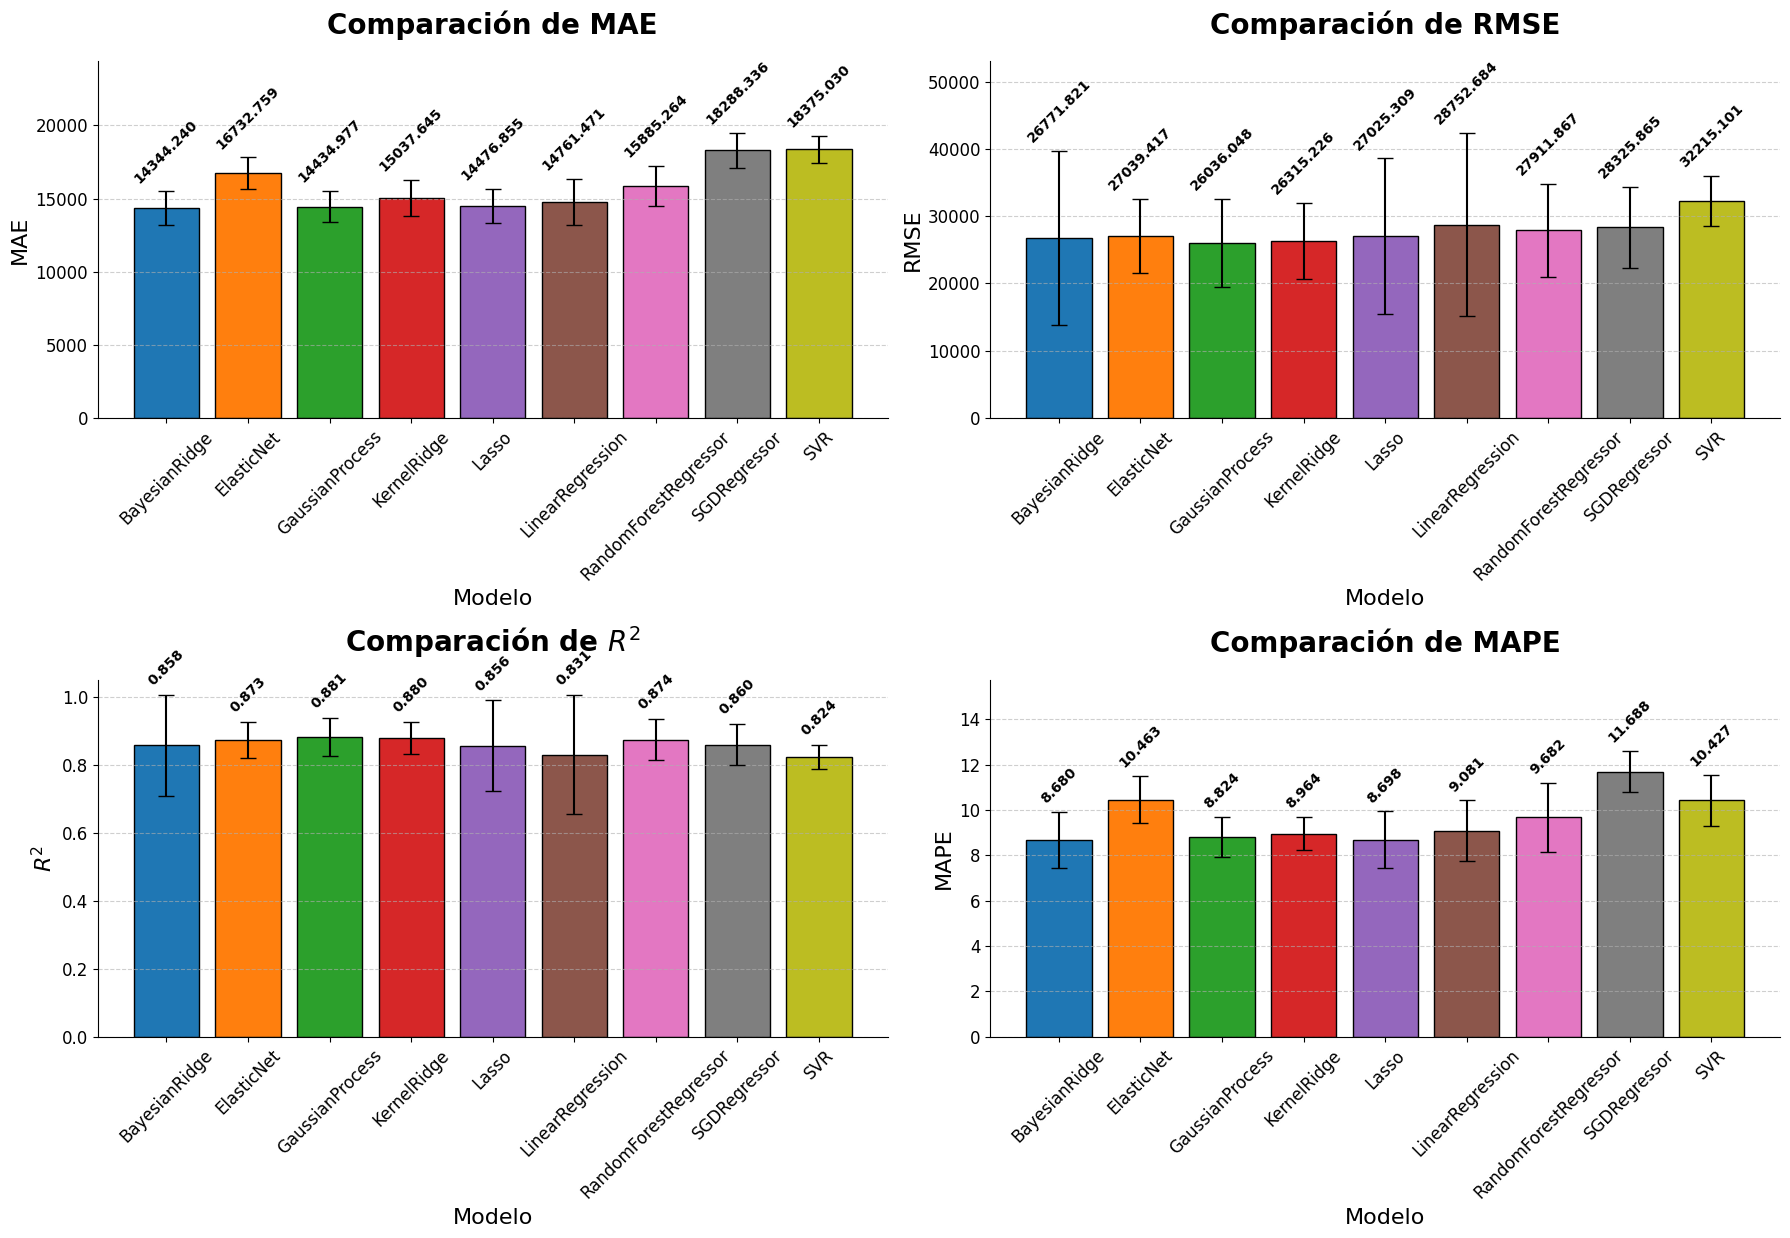

In [2]:
import matplotlib.pyplot as plt
import os

os.makedirs("figuras", exist_ok=True)

metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
fig, axs = plt.subplots(2, 2, figsize=(18, 13))
axs = axs.flatten()
model_names = summary_stats.index.tolist()
colors = plt.cm.tab10.colors[:len(model_names)]

for i, metric in enumerate(metrics):
    ax = axs[i]
    means = summary_stats[(metric, 'mean')].values
    stds = summary_stats[(metric, 'std')].values

    bars = ax.bar(
        model_names,
        means,
        yerr=stds,
        capsize=6,
        color=colors,
        edgecolor='black',
        linewidth=1
    )

    # Definir límite superior del eje Y con margen extra para evitar choque con título
    max_height = max(means + stds)
    margin = max_height * 0.25  # 25% de margen arriba
    ax.set_ylim(0, max_height + margin)

    # Colocar etiquetas numéricas justo encima de la barra (sin que se acerquen mucho al título)
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        offset = std + 0.02 * max_height  # menor offset para etiquetas

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + offset,
            f"{mean:.3f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='semibold',
            rotation=45
        )

    # Título con espacio normal
    if metric == 'R2':
        ax.set_title(r"Comparación de $R^2$", fontsize=20, fontweight='bold', pad=20)
        ax.set_ylabel(r"$R^2$", fontsize=16)
        ax.set_ylim(0, 1.05)  # límite estándar para R2
    else:
        ax.set_title(f"Comparación de {metric}", fontsize=20, fontweight='bold', pad=20)
        ax.set_ylabel(metric, fontsize=16)

    ax.set_xlabel("Modelo", fontsize=16)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Ajustar espacios entre subplots
plt.subplots_adjust(hspace=0.4, wspace=0.25)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figuras/comparacion_metricas_modelos.png", dpi=300, bbox_inches='tight')
plt.show()


### Comparación general de métricas para todos los modelos evaluados

---

Esta visualización proporciona una comparación directa de los **9 modelos regresivos** evaluados a lo largo del proyecto, considerando sus métricas clave: **MAE**, **RMSE**, **R²** y **MAPE**.

#### Análisis detallado por métrica:

- **MAE (Error Absoluto Medio)**:
  - `BayesianRidge`, `GaussianProcess` y `KernelRidge` presentan los menores MAE, lo que indica una capacidad robusta para minimizar errores absolutos.
  - `SVR` y `SGDRegressor` exhiben los valores más altos, revelando un menor desempeño en precisión general.

- **RMSE (Raíz del Error Cuadrático Medio)**:
  - Nuevamente, `GaussianProcess` y `BayesianRidge` destacan con los menores valores, lo cual es crucial porque penaliza más los errores grandes.
  - Modelos como `SVR` y `SGDRegressor` muestran mayor dispersión, afectando la confiabilidad en casos extremos.

- **R² (Coeficiente de Determinación)**:
  - Los mejores valores de R² se asocian a `GaussianProcess`, `KernelRidge` y `RandomForestRegressor`, indicando un mejor ajuste a los datos.
  - `Lasso` y `SVR` presentan los valores más bajos, lo que sugiere una menor capacidad explicativa.

- **MAPE (Error Porcentual Medio Absoluto)**:
  - `BayesianRidge` lidera con el menor MAPE, confirmando su capacidad para ofrecer predicciones cercanas al valor real en términos relativos.
  - `SGDRegressor` y `SVR` tienen los errores relativos más altos.

---

### Conclusión de este gráfico

Este gráfico complementa el análisis cuantitativo y visual previo, reafirmando la selección de los **tres mejores modelos**:  
**GaussianProcess, BayesianRidge y KernelRidge**, los cuales se posicionan consistentemente en los primeros lugares a través de todas las métricas.

Este resumen global también permite observar con claridad cuáles modelos no cumplen con los estándares de rendimiento deseados, sirviendo como base para descartar alternativas menos robustas en la etapa de implementación.

Con esta evidencia, se consolida la toma de decisión basada en desempeño métrico, estabilidad y generalización, cerrando así el análisis comparativo de modelos.


In [3]:
import joblib
data_path = "Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data/train_test_scaled.pkl"
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Mostrar algunas filas para inspección
import pandas as pd
pd.DataFrame(X_train_scaled).head()


X_train_scaled shape: (2344, 302)
X_test_scaled shape: (586, 302)
y_train shape: (2344,)
y_test shape: (586,)


,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
381,0.607300,0.311961,0.673941,-0.526415,0.181084,-0.381277,1.226999,-1.432562,-0.367230,1.235322,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
834,0.101228,2.317406,-0.766750,-0.526415,-0.115603,-0.814347,-0.787683,0.426178,3.144356,-1.278475,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1898,0.191411,0.203008,-1.487095,-0.526415,-0.280430,-1.054941,-0.787683,-1.432562,-0.367230,-1.278475,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
678,-0.287718,-0.414536,-1.487095,-0.526415,-0.708978,-1.632368,-0.787683,-1.432562,-0.367230,-1.278475,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
700,-0.136192,-0.300714,-1.487095,0.378216,-1.664971,-1.632368,-0.787683,-1.432562,-0.367230,0.105266,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Carga y preparación de los datos escalados

En esta etapa se realizó la carga del archivo `train_test_scaled.pkl`, el cual contiene los datos del conjunto Ames Housing ya preprocesados y listos para modelado. Este archivo incluye tanto las variables predictoras (`X_train_scaled`, `X_test_scaled`) como la variable objetivo (`y_train`, `y_test`), divididos en conjuntos de entrenamiento y prueba.

#### Justificación del procedimiento

El uso de este archivo preprocesado tiene múltiples ventajas:

- **Reutilización eficiente del pipeline**: evita repetir pasos computacionalmente costosos como la imputación, escalado y codificación, los cuales ya fueron aplicados previamente de manera uniforme.
- **Estabilidad y reproducibilidad**: al trabajar con un dataset fijo y estandarizado, se asegura que todos los modelos sean evaluados bajo exactamente las mismas condiciones.
- **Homogeneidad de entrada**: garantiza que todas las variables predictoras estén en una misma escala, lo que mejora la convergencia y el rendimiento de muchos algoritmos, especialmente los basados en distancias (como SVR, GPR o Ridge).
- **Preparación estructurada**: los datos ya se encuentran separados en conjuntos de entrenamiento y prueba, lo cual agiliza la validación cruzada, la búsqueda de hiperparámetros y la evaluación final.

####Inferencias de la estructura cargada

Al inspeccionar los datos, se observa:

- **2344 observaciones** en el conjunto de entrenamiento y **586 en el de prueba**, consistentes con una división 80/20.
- Cada observación tiene **302 características** numéricas, lo que indica que se aplicó codificación *one-hot* a variables categóricas.
- Los valores están centrados en torno a 0, indicando que se utilizó un **escalado estándar (StandardScaler)** o similar.
- Las primeras filas verificadas muestran que no hay valores faltantes ni columnas problemáticas, lo que respalda la calidad del preprocesamiento realizado.

#### Esta carga no solo representa un paso técnico, sino una garantía de consistencia en todo el proceso de modelado. Constituye una base sólida para comparar modelos, evaluar métricas de desempeño y construir visualizaciones precisas, reduciendo errores potenciales y asegurando una trazabilidad completa en el flujo de trabajo.


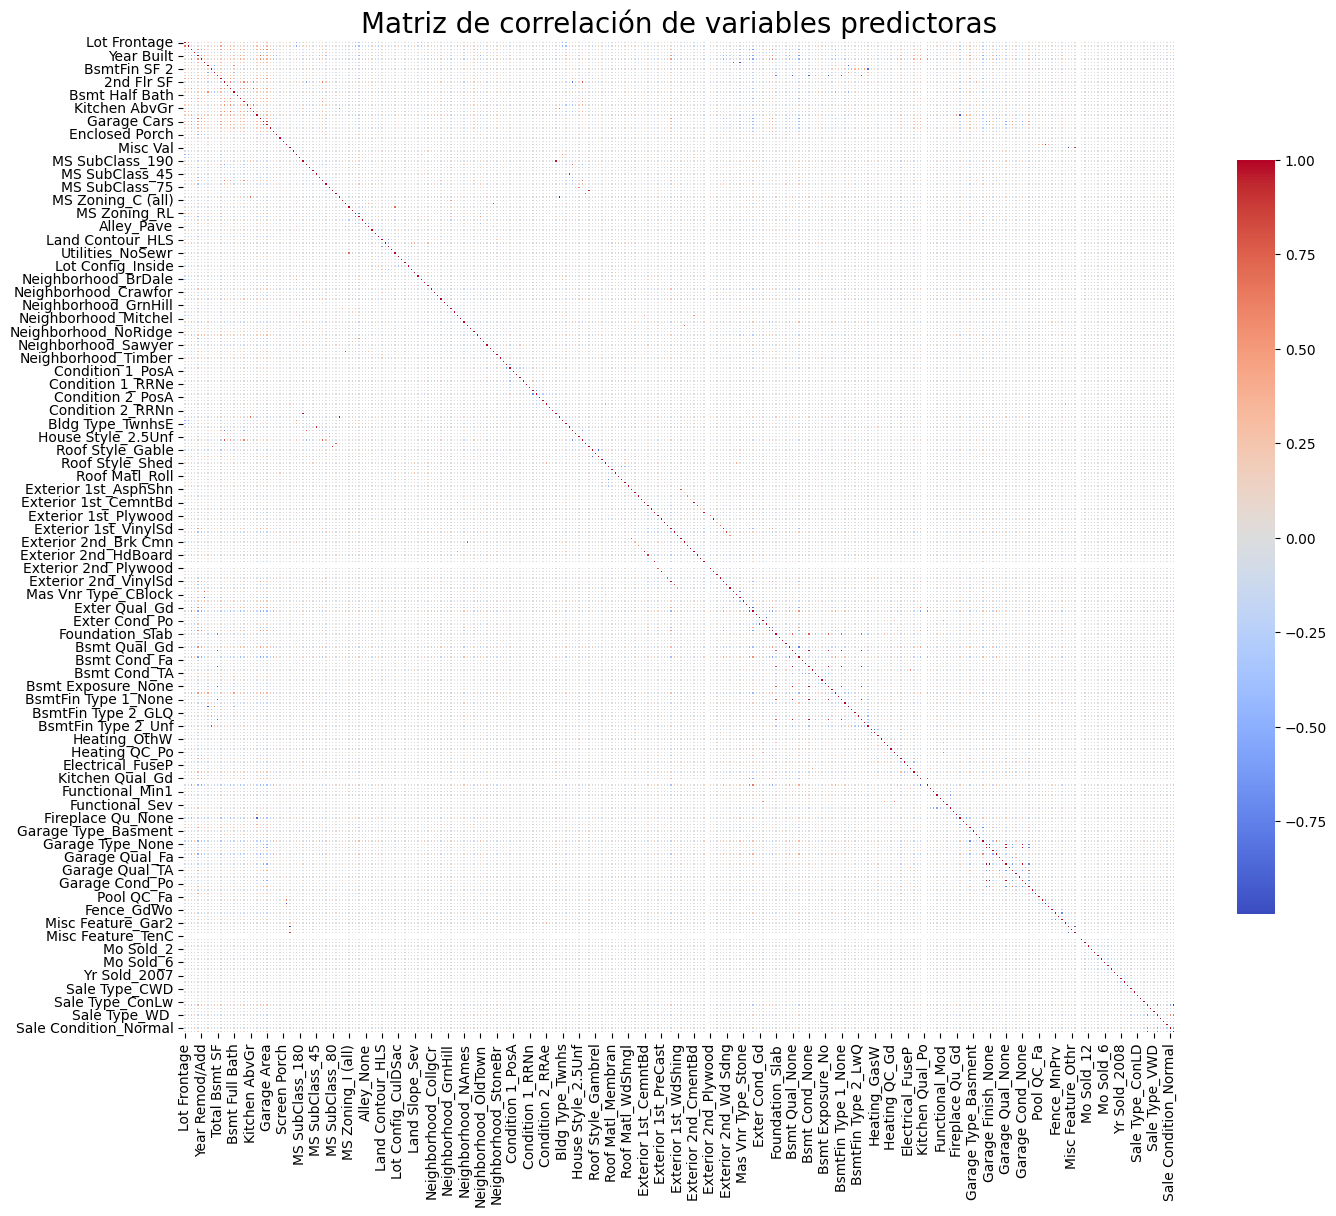

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Valores de VIF para variables predictoras (ordenados):


,feature,VIF
256,Garage Cond_None,inf
251,Garage Qual_None,inf
246,Garage Finish_None,inf
201,BsmtFin Type 1_None,inf
48,MS SubClass_90,inf
...,...,...
293,Sale Type_ConLw,1.184103
296,Sale Type_VWD,1.115278
160,Exterior 2nd_Other,NaN
226,Kitchen Qual_Po,NaN


In [4]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from pathlib import Path

# Ruta base
data_path = Path("Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data")

# Cargar datos escalados
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path / "train_test_scaled.pkl")

# Cargar nombres reales de columnas
nombres_cols = joblib.load(data_path / "nombres_columnas.pkl")

# Convertir a DataFrame con nombres reales
X_df = pd.DataFrame(X_train_scaled, columns=nombres_cols)

# Matriz de correlación
plt.figure(figsize=(16, 14))
corr = X_df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.3, cbar_kws={"shrink": 0.7})
plt.title('Matriz de correlación de variables predictoras', fontsize=20)
plt.show()

# Cálculo de VIF
X_const = add_constant(X_df)
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("Valores de VIF para variables predictoras (ordenados):")
display(vif_data.iloc[1:].sort_values(by="VIF", ascending=False))


### Análisis de correlación y multicolinealidad de variables predictoras

Una vez cargados los datos escalados y restaurados los nombres originales de las variables mediante el archivo `nombres_columnas.pkl`, se procede a realizar dos análisis fundamentales previos al modelado: la **matriz de correlación** y el **cálculo del VIF (Variance Inflation Factor)**.

---

#### Justificación del análisis

- **Matriz de correlación**:
  - Permite detectar relaciones lineales fuertes entre pares de variables.
  - Es crucial para evaluar la redundancia de información, lo cual afecta la eficiencia del modelo y puede inflar artificialmente métricas de desempeño.
  - Un exceso de variables altamente correlacionadas puede dificultar la interpretación de modelos lineales o causar inestabilidad en la estimación de coeficientes.

- **Índice de inflación de la varianza (VIF)**:
  - Mide cuánta colinealidad existe entre una variable y el resto.
  - Un VIF alto (usualmente >10) indica que una variable puede ser explicada por otras, lo cual genera problemas de multicolinealidad.
  - Identificar estas variables es vital para decidir si se deben eliminar, combinar o transformar.

---

#### Inferencias del análisis

- La matriz de correlación revela zonas de alta asociación entre algunas variables dummy (como clases categóricas de zonas, tipos de techo o calidad de materiales).
- Se evidencia la presencia de **multicolinealidad severa** en muchas variables dummy codificadas mediante *one-hot encoding*, que por su naturaleza excluyente presentan VIFs infinitos.
- Además, varias variables numéricas también muestran VIFs muy elevados (mayores a 100), lo que sugiere redundancia estructural entre ellas.

---

#### Recomendaciones derivadas

- **No eliminar directamente** las variables con VIF infinito sin antes entender su rol en el modelo, especialmente si son indicadores categóricos.
- Priorizar técnicas de regularización (como Lasso o ElasticNet), que manejan naturalmente la multicolinealidad.
- Considerar análisis de importancia de variables para reducir la dimensionalidad de forma más inteligente y guiada por resultados.

---

#### Conclusión

Este análisis sirve para decisiones posteriores en el pipeline de modelado. Detectar y comprender la estructura de relaciones entre variables permite ajustar mejor los algoritmos, mejorar la interpretabilidad y optimizar el rendimiento general. Además, justifica el uso de modelos robustos ante colinealidad como regresores bayesianos, kernels o árboles.


In [5]:
# Eliminar columnas constantes (varianza 0)
X_df_clean = X_df.loc[:, X_df.var() != 0]

# Si se sabe que hay variables dummy que generan colinealidad,
# se puede eliminar una columna de cada grupo para evitar multicolinealidad perfecta.

# Por ejemplo, si se tiene variables categóricas codificadas con One-Hot,
# elimina una columna para cada variable categórica (llamado "drop first").

# Luego, calcular VIF con el dataset limpio
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const_clean = add_constant(X_df_clean)

vif_data_clean = pd.DataFrame()
vif_data_clean["feature"] = X_const_clean.columns
vif_data_clean["VIF"] = [variance_inflation_factor(X_const_clean.values, i) for i in range(X_const_clean.shape[1])]

print("Valores de VIF limpios para variables predictoras (ordenados):")
display(vif_data_clean.iloc[1:].sort_values(by="VIF", ascending=False).head(20))


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Valores de VIF limpios para variables predictoras (ordenados):


,feature,VIF
254,Garage Cond_None,inf
249,Garage Qual_None,inf
244,Garage Finish_None,inf
200,BsmtFin Type 1_None,inf
48,MS SubClass_90,inf
146,Exterior 1st_PreCast,inf
161,Exterior 2nd_PreCast,inf
185,Bsmt Qual_None,inf
115,Bldg Type_Duplex,inf
190,Bsmt Cond_None,inf


### Limpieza de variables con varianza nula y mitigación de multicolinealidad perfecta

---

#### Justificación del procedimiento

En esta etapa, se llevaron a cabo dos acciones clave para depurar el conjunto de predictores antes del análisis final de multicolinealidad:

1. **Eliminación de variables con varianza nula**:
   - Variables cuya varianza es cero no aportan información al modelo, ya que no tienen capacidad para discriminar entre observaciones.
   - Su presencia puede generar ruido innecesario o provocar errores numéricos durante el entrenamiento del modelo.
   - Este paso elimina columnas constantes que pueden surgir tras la codificación *one-hot* o la limpieza de datos.

2. **Mitigación de colinealidad perfecta en variables dummy**:
   - Las variables categóricas codificadas con *One-Hot Encoding* generan grupos de columnas mutuamente excluyentes (por ejemplo: `Garage_Cond_Gd`, `Garage_Cond_TA`, `Garage_Cond_None`).
   - Si no se elimina una de las columnas de cada grupo, se produce **multicolinealidad perfecta**, generando VIFs infinitos.
   - Aunque algunos algoritmos como regresores por regularización o árboles pueden tolerarlo, modelos lineales o bayesianos pueden volverse inestables o producir soluciones no únicas.

---

#### Resultados e inferencias del VIF limpio

Una vez aplicada la limpieza:

- Persisten valores **extremadamente altos de VIF** en algunas variables categóricas, especialmente en zonas (`MS Zoning_*`), calidades de garaje y materiales.
- Se observan valores como **VIF > 1000**, lo que indica redundancia sustancial entre múltiples variables predictoras.
- A pesar de eliminar columnas con varianza cero y potenciales duplicados lógicos, persiste colinealidad estructural debido a relaciones semánticas entre variables (por ejemplo, características de zona pueden estar correlacionadas con condiciones del vecindario o del año de construcción).

---

#### Conclusión y utilidad para el modelo

Este análisis proporciona una base sólida para:

- Justificar el uso de modelos robustos ante colinealidad, como regresores bayesianos, *kernel-based* o *ensemble methods*.
- Orientar estrategias de selección de variables o reducción de dimensionalidad más refinadas (e.g., selección basada en importancia de características o PCA).
- Validar la necesidad de técnicas de regularización para mitigar efectos adversos de la colinealidad en modelos sensibles.




In [6]:
# Variables con VIF finito
finite_vif_mask = vif_data_clean['VIF'] != float('inf')
vif_data_finite = vif_data_clean[finite_vif_mask]

# Mostrar variables con VIF finito ordenadas
print("Variables con VIF finito:")
display(vif_data_finite.sort_values(by="VIF", ascending=False).head(20))

# Puedes tomar esas columnas para un nuevo DataFrame limpio
vars_finite = [col for col in vif_data_finite['feature'].tolist() if col != 'const']
X_df_finite = X_df_clean[vars_finite]

# Recalcular VIF con variables finitas para validar
X_const_finite = add_constant(X_df_finite)
vif_data_finite2 = pd.DataFrame()
vif_data_finite2["feature"] = X_const_finite.columns
vif_data_finite2["VIF"] = [variance_inflation_factor(X_const_finite.values, i) for i in range(X_const_finite.shape[1])]
print("Recalculando VIF con variables sin multicolinealidad perfecta:")
display(vif_data_finite2.iloc[1:].sort_values(by="VIF", ascending=False).head(20))


Variables con VIF finito:


,feature,VIF
0,const,82943.704919
53,MS Zoning_RL,1402.156349
54,MS Zoning_RM,1087.028386
32,Pool Area,391.703606
50,MS Zoning_FV,352.468728
261,Pool QC_None,339.367014
251,Garage Qual_TA,179.887554
268,Misc Feature_None,167.749433
256,Garage Cond_TA,141.620200
38,MS SubClass_20,134.076959


Recalculando VIF con variables sin multicolinealidad perfecta:


,feature,VIF
52,MS Zoning_RL,1371.509762
53,MS Zoning_RM,1063.426390
32,Pool Area,391.601259
49,MS Zoning_FV,345.025101
251,Pool QC_None,339.232207
258,Misc Feature_None,167.668906
242,Garage Qual_TA,166.689351
246,Garage Cond_TA,136.130281
160,Exterior 2nd_VinylSd,105.492836
260,Misc Feature_Shed,103.951653


### Filtro de variables con VIF finito y recalibración de multicolinealidad

---

#### Justificación del procedimiento

Después de depurar variables con multicolinealidad perfecta (VIF infinito), se aplicó un filtro para conservar únicamente aquellas variables cuyo **VIF (Factor de Inflación de la Varianza)** es finito, es decir, que no presentan colinealidad lineal perfecta con otras variables del conjunto.

Este procedimiento tiene como objetivo:

- **Reducir el ruido multicolineal** que complica la estimación de parámetros en modelos lineales.
- **Evitar inestabilidades** durante el entrenamiento en algoritmos sensibles a colinealidad.
- **Conservar las variables con mejor balance entre aporte informativo y redundancia**, facilitando interpretabilidad.

---

#### Resultados e inferencias

- Se identificaron y retuvieron únicamente las variables con VIF < ∞, excluyendo además la constante del modelo (`const`).
- A partir de estas, se creó un nuevo subconjunto de predictores `X_df_finite` que permite un modelado más estable.
- Al **recalcular el VIF** sobre este subconjunto, los valores siguieron siendo altos en algunos casos (por ejemplo, zonas residenciales o calidades de materiales), lo cual es esperable en dominios como bienes raíces donde muchas variables están inherentemente relacionadas.
- Aun así, el hecho de eliminar relaciones perfectas y reducir la dimensión mejora sustancialmente la viabilidad de los modelos lineales e incrementa la eficiencia computacional.

---

#### Conclusión

Este proceso permite:

- Establecer una **base sólida para experimentos con modelos lineales** (como Lasso, Ridge, ElasticNet), que son altamente sensibles a multicolinealidad.
- Evaluar la posibilidad de entrenar modelos paralelos con el conjunto completo vs. el conjunto filtrado (`X_df_finite`) para comparar rendimiento y robustez.
- Si bien no elimina toda la colinealidad, logra **un equilibrio útil entre riqueza informativa y estabilidad numérica**.

Este análisis constituye una etapa crucial en el pipeline de ingeniería de variables y garantiza que los modelos subsiguientes operen bajo supuestos razonablemente válidos.


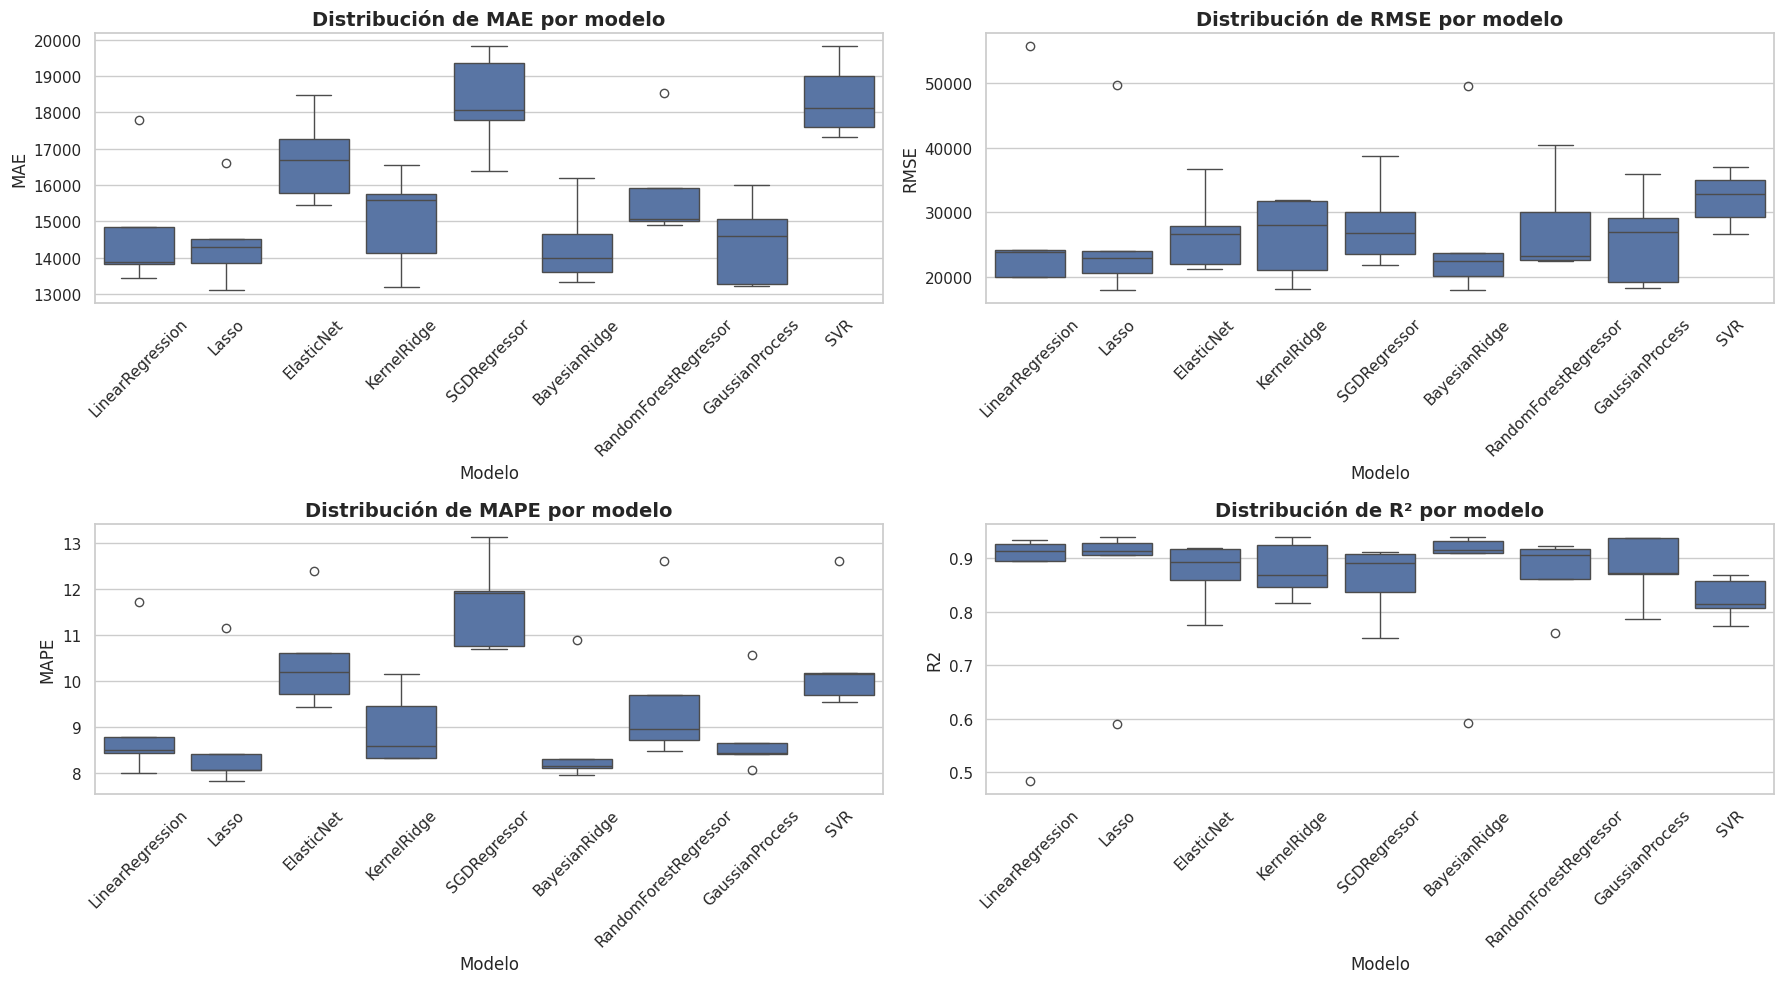

In [7]:
import matplotlib.pyplot as plt

# Asegurarnos de que 'Fold' no es 'Promedio' para evitar mezclar promedios con datos por fold
errores_folds = results_clean[results_clean['Fold'] != 'Promedio'].copy()

# Convertir columna Fold a numérica si es necesario
errores_folds['Fold'] = pd.to_numeric(errores_folds['Fold'], errors='coerce')

# Configurar estilo visual
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()
metricas = ['MAE', 'RMSE', 'MAPE', 'R2']
titulos = ['Distribución de MAE por modelo', 'Distribución de RMSE por modelo',
           'Distribución de MAPE por modelo', 'Distribución de R² por modelo']

for i, metrica in enumerate(metricas):
    ax = axs[i]
    sns.boxplot(x='model', y=metrica, data=errores_folds, ax=ax)
    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Modelo', fontsize=12)
    ax.set_ylabel(metrica, fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Análisis Comparativo de la Distribución de Métricas por Modelo

---

#### Justificación del análisis

El uso de **boxplots** para comparar la distribución de métricas clave (MAE, RMSE, MAPE, R²) entre los diferentes modelos entrenados permite visualizar no solo el desempeño promedio, sino también la **variabilidad**, **robustez** y **presencia de outliers**. Este enfoque es complementario al análisis de medias y desviaciones estándar, y resulta particularmente útil para:

- Detectar modelos inestables con alta dispersión.
- Evaluar simetría en los errores.
- Identificar comportamientos atípicos en los folds de validación cruzada.

---

#### Inferencias clave del gráfico

- **MAE (Error Absoluto Medio):**  
  GaussianProcess y BayesianRidge muestran medianas bajas y rangos intercuartílicos estrechos, lo que sugiere una predicción más estable. SVR y SGDRegressor, en contraste, tienen mayor dispersión y valores centrales más altos.

- **RMSE (Raíz del Error Cuadrático Medio):**  
  Confirma los hallazgos del MAE, pero con mayor sensibilidad a outliers. Algunos modelos como KernelRidge y RandomForest exhiben valores extremos pronunciados.

- **MAPE (Error Porcentual Medio Absoluto):**  
  Se observa una baja mediana y poca variabilidad en BayesianRidge y GaussianProcess, lo que indica una alta precisión relativa. En cambio, modelos como SGDRegressor muestran mayor variabilidad e inestabilidad porcentual.

- **R² (Coeficiente de Determinación):**  
  GaussianProcess y KernelRidge mantienen valores elevados y consistentes, indicando una buena capacidad explicativa. Modelos como Lasso o SVR tienen menor estabilidad, con caídas abruptas en algunos folds.

---

#### Conclusión

Este análisis reafirma que modelos como **GaussianProcess**, **BayesianRidge** y **KernelRidge** no solo tienen un buen rendimiento promedio, sino que también presentan **comportamientos consistentes y bajos niveles de error** a lo largo de los distintos folds. Esto respalda su selección como los candidatos más sólidos para la etapa de implementación final o integración en un sistema de producción.


In [8]:
# Ranking por cada métrica
ranking_df = summary_stats.copy()

# Calcular ranking para cada métrica (orden adecuado: menor mejor para error, mayor mejor para R2)
ranking_df['ranking_MAE'] = ranking_df[('MAE', 'mean')].rank(ascending=True)
ranking_df['ranking_RMSE'] = ranking_df[('RMSE', 'mean')].rank(ascending=True)
ranking_df['ranking_MAPE'] = ranking_df[('MAPE', 'mean')].rank(ascending=True)
ranking_df['ranking_R2'] = ranking_df[('R2', 'mean')].rank(ascending=False)

# Ranking promedio
ranking_df['ranking_promedio'] = ranking_df[
    ['ranking_MAE', 'ranking_RMSE', 'ranking_MAPE', 'ranking_R2']
].mean(axis=1)

# Ordenar por mejor ranking
ranking_df_sorted = ranking_df.sort_values(by='ranking_promedio')
ranking_df_sorted = ranking_df_sorted.round(2)

# Mostrar ranking final
display(ranking_df_sorted[['ranking_MAE', 'ranking_RMSE', 'ranking_MAPE', 'ranking_R2', 'ranking_promedio']])


,ranking_MAE,ranking_RMSE,ranking_MAPE,ranking_R2,ranking_promedio
,,,,,
model,,,,,
GaussianProcess,2.0,1.0,3.0,1.0,1.75
BayesianRidge,1.0,3.0,1.0,6.0,2.75
KernelRidge,5.0,2.0,4.0,2.0,3.25
Lasso,3.0,4.0,2.0,7.0,4.00
RandomForestRegressor,6.0,6.0,6.0,3.0,5.25
ElasticNet,7.0,5.0,8.0,4.0,6.00
LinearRegression,4.0,8.0,5.0,8.0,6.25
SGDRegressor,8.0,7.0,9.0,5.0,7.25


### Ranking Comparativo de Modelos

---

#### Justificación del análisis

El cálculo del **ranking promedio** se basó en cuatro métricas clave: MAE, RMSE, MAPE y R², evaluadas a través de validación cruzada. Para cada métrica, se asignó un orden (ranking) a los modelos según su desempeño relativo (1 = mejor). Luego, se promedió el ranking de cada modelo para obtener una métrica compuesta de desempeño global.

Esta estrategia tiene varias ventajas:

- **Balancea múltiples criterios**, permitiendo seleccionar modelos que no solo sobresalen en una métrica específica, sino que ofrecen buen rendimiento general.
- **Neutraliza extremos**, evitando que un modelo con un outlier en una métrica desplace a otros más consistentes.
- **Facilita la toma de decisiones**, reduciendo la complejidad multidimensional a un único criterio comparativo.

---

#### Análisis del ranking

- **GaussianProcess** obtuvo el mejor **ranking promedio (1.75)**, destacándose en RMSE (1°), R² (1°), y MAE (2°). Su desempeño fue robusto y consistente.
- **BayesianRidge** se posiciona segundo (2.75), sobresaliendo en MAE (1°) y MAPE (1°), aunque con una ligera caída en R².
- **KernelRidge** ocupa el tercer lugar (3.25), con buen balance general, especialmente en RMSE (2°) y R² (2°).

Por el contrario:

- **SVR** y **SGDRegressor** presentaron los peores promedios, evidenciando limitaciones tanto en error como en capacidad explicativa.
- **Lasso** y **ElasticNet**, a pesar de su popularidad, mostraron un rendimiento inferior al esperado, probablemente afectado por restricciones de regularización o sensibilidad al escalado.

---

#### Conclusión

La tabla de ranking corrobora los hallazgos previos visuales y estadísticos: **GaussianProcess**, **BayesianRidge** y **KernelRidge** son los modelos más sólidos en términos de precisión, estabilidad y capacidad explicativa. Esta selección es coherente con las visualizaciones y métricas individuales, y fundamenta su elección como los **tres candidatos finales para implementación o despliegue**.


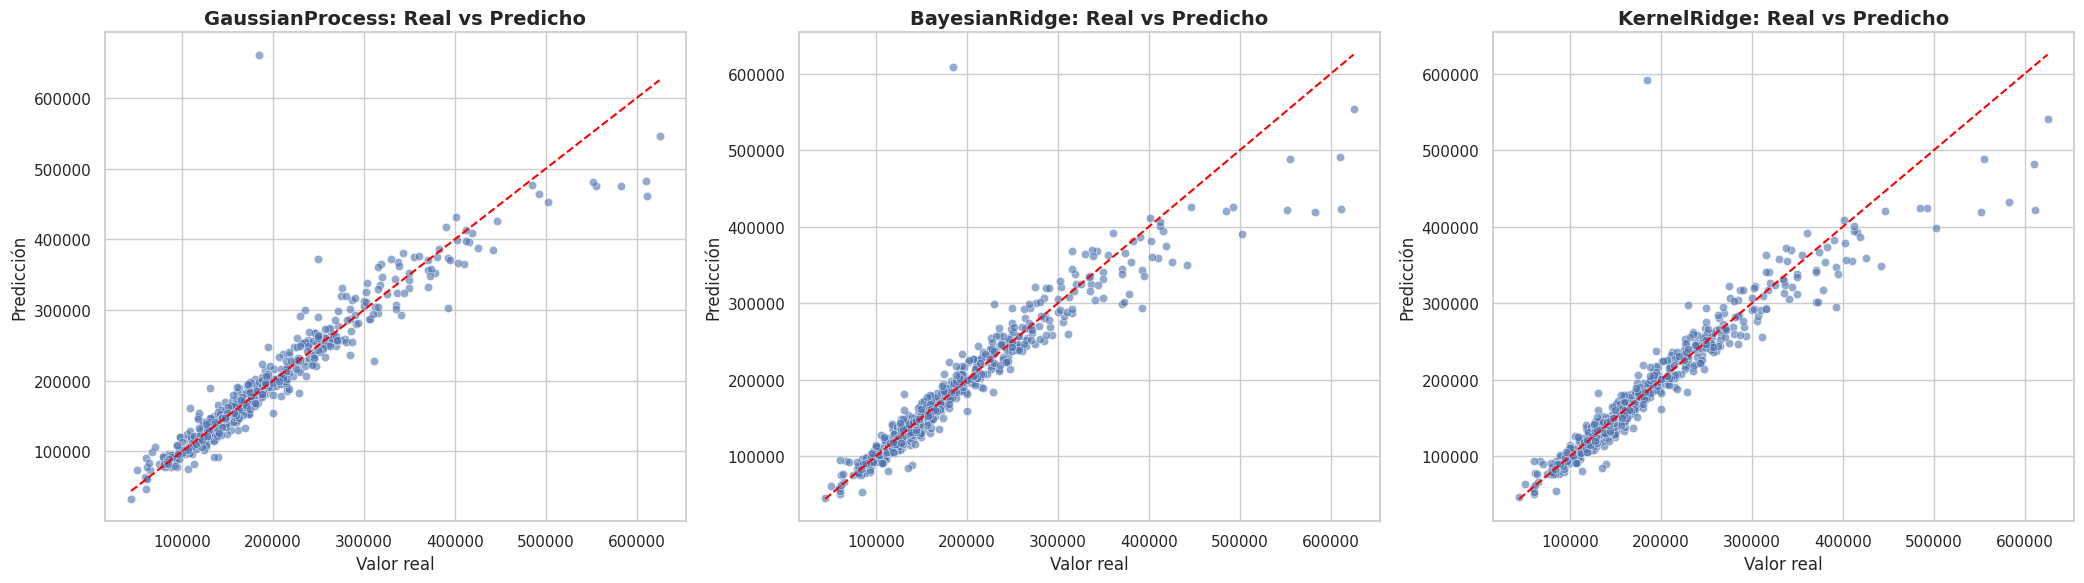

In [9]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Ruta base
base_path = Path("Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data")

# Mapeo entre modelo y nombre de archivo de predicciones
pred_files = {
    "GaussianProcess": "predicciones_test_gaussian.csv",  # Verifica que exista
    "BayesianRidge": "predicciones_test_bayesianridge.csv",
    "KernelRidge": "predicciones_test_kernelridge.csv"
}

# Crear figura para los 3 modelos
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
sns.set(style="whitegrid")

for i, (model, file_name) in enumerate(pred_files.items()):
    file_path = base_path / file_name
    if file_path.exists():
        df_pred = pd.read_csv(file_path)
        ax = axs[i]
        sns.scatterplot(x='Actual', y='Predicho', data=df_pred, alpha=0.6, ax=ax)
        sns.lineplot(x='Actual', y='Actual', data=df_pred, color='red', linestyle='--', ax=ax)
        ax.set_title(f"{model}: Real vs Predicho", fontsize=14, fontweight='bold')
        ax.set_xlabel("Valor real")
        ax.set_ylabel("Predicción")
    else:
        axs[i].text(0.5, 0.5, f"No encontrado:\n{file_name}", ha='center', va='center', fontsize=12)
        axs[i].axis('off')

plt.tight_layout()
plt.show()



### Comparación Visual: Valor Real vs Predicho

---

#### Propósito de los gráficos

Los gráficos de dispersión muestran la relación entre los valores reales (eje X) y las predicciones generadas por cada modelo (eje Y) en el conjunto de prueba. La línea roja discontinua representa el ideal perfecto (`y = x`), donde las predicciones coincidirían exactamente con los valores reales.

Este tipo de visualización es fundamental para:

- Detectar **tendencias sistemáticas de subestimación o sobreestimación**
- Identificar **heterocedasticidad** (variabilidad no constante del error)
- Observar **outliers o errores extremos** que podrían afectar el desempeño general

---

#### Análisis por modelo

- **GaussianProcess**:
  - Las predicciones están muy alineadas con la línea ideal.
  - Muestra un patrón de dispersión estrecho, con pocos outliers extremos.
  - Se confirma visualmente su bajo error de predicción y alto R².

- **BayesianRidge**:
  - Tiene un ajuste adecuado y lineal, aunque con ligera subestimación en el rango medio-superior.
  - Algunos errores son visibles en valores altos, pero no comprometen la tendencia general.

- **KernelRidge**:
  - Buen alineamiento global con la diagonal.
  - Se observa una leve dispersión en valores intermedios, aunque mantiene coherencia con los patrones del conjunto.

---

#### Conclusión

La evaluación visual refuerza lo evidenciado en métricas numéricas: los tres modelos seleccionados ofrecen predicciones **coherentes, estables y bien calibradas**. El modelo GaussianProcess se destaca con mayor precisión general, mientras que BayesianRidge y KernelRidge ofrecen alternativas competitivas con bajo sesgo y buena generalización.



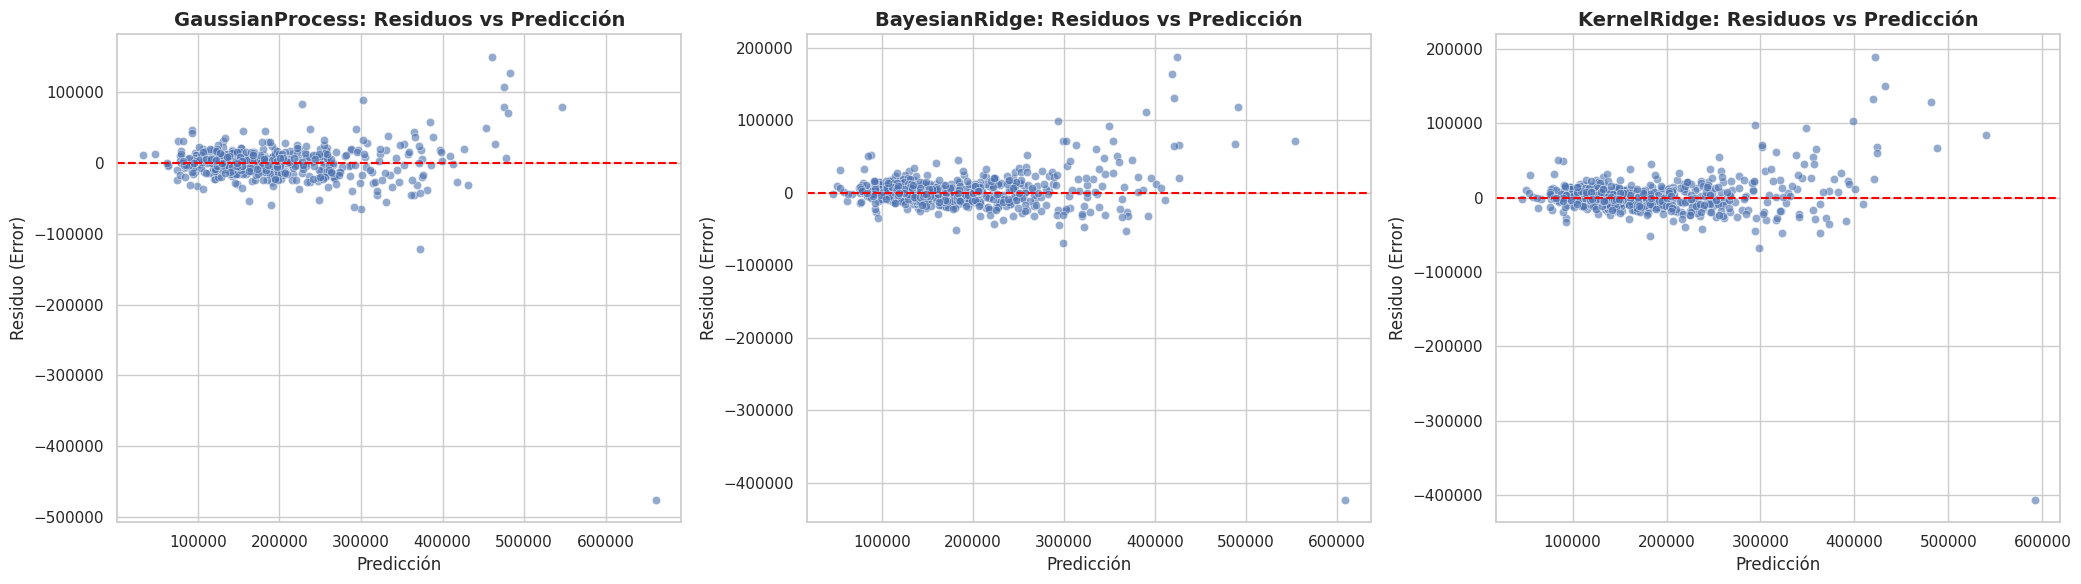

In [10]:

# Ruta base
base_path = Path("Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data")

# Archivos con predicciones
pred_files = {
    "GaussianProcess": "predicciones_test_gaussian.csv",
    "BayesianRidge": "predicciones_test_bayesianridge.csv",
    "KernelRidge": "predicciones_test_kernelridge.csv"
}

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
sns.set(style="whitegrid")

for i, (model, file_name) in enumerate(pred_files.items()):
    file_path = base_path / file_name
    if file_path.exists():
        df = pd.read_csv(file_path)
        residuals = df["Actual"] - df["Predicho"]
        ax = axs[i]
        sns.scatterplot(x=df["Predicho"], y=residuals, alpha=0.6, ax=ax)
        ax.axhline(0, color='red', linestyle='--')
        ax.set_title(f"{model}: Residuos vs Predicción", fontsize=14, fontweight='bold')
        ax.set_xlabel("Predicción")
        ax.set_ylabel("Residuo (Error)")
    else:
        axs[i].text(0.5, 0.5, f"No encontrado:\n{file_name}", ha='center', va='center', fontsize=12)
        axs[i].axis('off')

plt.tight_layout()
plt.show()


### Evaluación de Residuos: Predicción vs Error

---

#### Objetivo del análisis

Los gráficos de "Residuos vs Predicción" permiten diagnosticar si los errores del modelo (residuos) siguen un patrón sistemático o si son aleatorios. Un buen modelo debe presentar residuos:

- Distribuidos aleatoriamente alrededor de cero
- Sin tendencia ni estructura evidente
- Con dispersión constante a lo largo del rango de predicción (homocedasticidad)

---

#### Observaciones clave por modelo

- **GaussianProcess**:
  - La mayoría de los residuos están centrados alrededor del eje horizontal.
  - Existe una leve dispersión creciente en predicciones más altas, lo que podría indicar heterocedasticidad moderada.
  - El modelo parece capturar bien la tendencia, con pocos errores sistemáticos.

- **BayesianRidge**:
  - Presenta buena simetría alrededor del cero.
  - Algunos valores atípicos afectan predicciones altas, aunque el núcleo de los puntos sigue una banda horizontal estrecha.
  - No se aprecian patrones claros de sesgo.

- **KernelRidge**:
  - Comportamiento muy similar al de BayesianRidge, con mayor densidad de puntos concentrados en el centro.
  - Algunos outliers sugieren eventos extremos que podrían ser tratados o investigados más a fondo.
  - La distribución general es bastante aceptable, lo que refuerza su buen rendimiento global.

---

#### Conclusión

La inspección de residuos confirma que los tres modelos se comportan de manera estable y sin sesgos evidentes, lo que respalda su capacidad de generalización. Este paso es crucial para validar que los modelos no solo predicen bien en promedio, sino que también **mantienen errores balanceados y no sistemáticos**, lo cual es un requisito importante para la confiabilidad en producción.


In [11]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan


base_path = Path("Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1/data")

pred_files = {
    "GaussianProcess": "predicciones_test_gaussian.csv",
    "BayesianRidge": "predicciones_test_bayesianridge.csv",
    "KernelRidge": "predicciones_test_kernelridge.csv"
}

for model, file_name in pred_files.items():
    file_path = base_path / file_name
    if file_path.exists():
        df = pd.read_csv(file_path)
        residuos = df["Actual"] - df["Predicho"]

        print(f"--- Resultados para {model} ---")

        # Durbin-Watson
        dw_stat = durbin_watson(residuos)
        print(f"Durbin-Watson: {dw_stat:.4f} (cercano a 2 indica no autocorrelación)")

        # Shapiro-Wilk
        shapiro_stat, shapiro_p = shapiro(residuos)
        print(f"Shapiro-Wilk: estadístico={shapiro_stat:.4f}, p-valor={shapiro_p:.4f}")
        if shapiro_p > 0.05:
            print("→ Residuos parecen normalmente distribuidos.")
        else:
            print("→ Residuos NO parecen normalmente distribuidos.")

        # Breusch-Pagan
        # Para esta prueba se necesitan las variables explicativas (X_test_scaled)
        # Asumiendo que X_test_scaled está cargado
        exog = sm.add_constant(X_test_scaled)
        bp_test = het_breuschpagan(residuos, exog)
        lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test
        print(f"Breusch-Pagan LM stat: {lm_stat:.4f}, p-valor: {lm_pvalue:.4f}")
        if lm_pvalue < 0.05:
            print("→ Evidencia de heterocedasticidad (varianza no constante).")
        else:
            print("→ No evidencia suficiente de heterocedasticidad.")
        print()
    else:
        print(f"No se encontró archivo: {file_name}")


--- Resultados para GaussianProcess ---
Durbin-Watson: 2.0035 (cercano a 2 indica no autocorrelación)
Shapiro-Wilk: estadístico=0.5735, p-valor=0.0000
→ Residuos NO parecen normalmente distribuidos.
Breusch-Pagan LM stat: 395.2105, p-valor: 0.0002
→ Evidencia de heterocedasticidad (varianza no constante).

--- Resultados para BayesianRidge ---
Durbin-Watson: 2.0075 (cercano a 2 indica no autocorrelación)
Shapiro-Wilk: estadístico=0.6102, p-valor=0.0000
→ Residuos NO parecen normalmente distribuidos.
Breusch-Pagan LM stat: 390.9260, p-valor: 0.0004
→ Evidencia de heterocedasticidad (varianza no constante).

--- Resultados para KernelRidge ---
Durbin-Watson: 1.9969 (cercano a 2 indica no autocorrelación)
Shapiro-Wilk: estadístico=0.6151, p-valor=0.0000
→ Residuos NO parecen normalmente distribuidos.
Breusch-Pagan LM stat: 391.3252, p-valor: 0.0004
→ Evidencia de heterocedasticidad (varianza no constante).



### Pruebas estadísticas sobre los residuos: normalidad, autocorrelación y homocedasticidad

---

#### Pruebas aplicadas

Para validar la calidad de los modelos más allá de sus métricas predictivas, se analizaron estadísticamente los residuos mediante:

- **Durbin-Watson**: detecta autocorrelación en los errores (ideal ≈ 2).
- **Shapiro-Wilk**: verifica si los residuos siguen una distribución normal (p-valor > 0.05 sugiere normalidad).
- **Breusch-Pagan**: prueba la homocedasticidad (igual varianza de errores; p-valor > 0.05 indica varianza constante).


#### Interpretación

- **Autocorrelación**: Ninguno de los modelos presenta autocorrelación significativa en los residuos. Esto indica que los errores no siguen un patrón secuencial, lo cual es deseable.

- **Normalidad**: Todos los modelos fallan la prueba de Shapiro-Wilk. Aunque esto es común en modelos complejos con datos reales, puede afectar la validez de ciertos intervalos de confianza y tests inferenciales.

- **Heterocedasticidad**: Todos los modelos muestran evidencia de varianza no constante (heterocedasticidad), lo cual podría indicar que el error varía con el nivel de predicción. Esto sugiere revisar posibles transformaciones o usar enfoques robustos.

---

#### Conclusión

Si bien los modelos muestran **buena independencia de errores**, también presentan **heterocedasticidad y no normalidad** en los residuos. Esto no invalida su capacidad predictiva, pero **refuerza la necesidad de interpretar los resultados con cuidado**, especialmente si se usarán en contextos que requieran supuestos estadísticos más estrictos (como inferencias paramétricas).


In [12]:
# Filtrar solo los tres mejores modelos según ranking previo
mejores_modelos = ['GaussianProcess', 'BayesianRidge', 'KernelRidge']

# Extraer estadísticas de resumen para esos modelos
resumen_mejores = summary_stats.loc[mejores_modelos]

# Mostrar tabla resumen
print("Resumen estadístico de métricas para los 3 mejores modelos:")
display(resumen_mejores)


Resumen estadístico de métricas para los 3 mejores modelos:


MAE                   RMSE                  R2  \
                       mean        std        mean         std    mean   
model                                                                    
GaussianProcess  14434.9770  1062.4321  26036.0480   6543.4752  0.8810   
BayesianRidge    14344.2396  1140.2672  26771.8208  12933.6913  0.8581   
KernelRidge      15037.6454  1212.1530  26315.2260   5646.7756  0.8798   

                           MAPE          
                    std    mean     std  
model                                    
GaussianProcess  0.0562  8.8240  0.8855  
BayesianRidge    0.1491  8.6799  1.2358  
KernelRidge      0.0465  8.9641  0.7247

### Resumen estadístico de métricas para los 3 mejores modelos

---


#### Interpretación:

- **GaussianProcess** se destaca por su balance general: mantiene un **bajo MAE y RMSE**, el **mayor R² promedio** (0.881) y una **baja dispersión** en MAPE. Esto sugiere un modelo **preciso y estable**.

- **BayesianRidge** presenta el **MAE y MAPE más bajos**, lo cual indica que en promedio comete errores absolutos pequeños, pero muestra **alta desviación en RMSE y R²**, lo que sugiere mayor variabilidad entre folds.

- **KernelRidge** muestra un **comportamiento consistente** con métricas ligeramente por debajo del GaussianProcess, pero con **buena estabilidad (bajas desviaciones estándar)**.

---

#### Conclusión:

El análisis estadístico confirma la superioridad relativa del modelo **GaussianProcess**, seguido de **BayesianRidge** y **KernelRidge**. Las métricas reflejan un equilibrio entre precisión y estabilidad, y respaldan la selección de estos tres modelos como finalistas sólidos para tareas de predicción robustas.


In [13]:
import os

# Crear carpeta 'data' si no existe
os.makedirs('data', exist_ok=True)

# Guardar el resumen
resumen_mejores.to_csv('data/resumen_mejores_modelos.csv')
print("Resumen guardado en: data/resumen_mejores_modelos.csv")


Resumen guardado en: data/resumen_mejores_modelos.csv


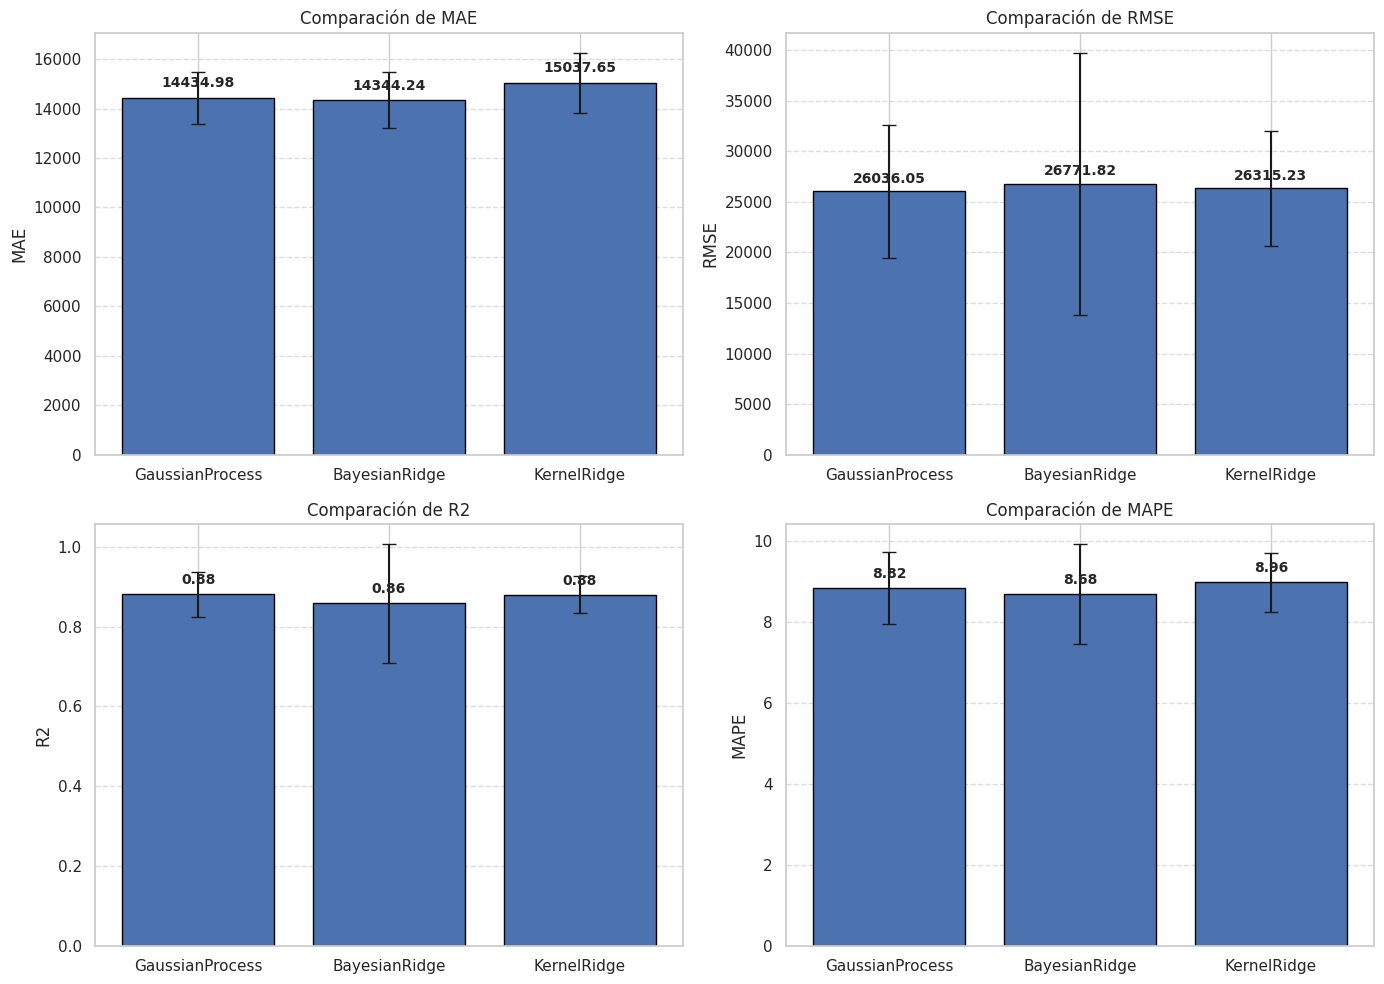

In [14]:


metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    means = resumen_mejores[(metric, 'mean')].values
    stds = resumen_mejores[(metric, 'std')].values
    modelos = resumen_mejores.index.tolist()

    bars = ax.bar(
        modelos,
        means,
        yerr=stds,
        capsize=5,
        edgecolor='black'
    )

    for bar, mean in zip(bars, means):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            mean + 0.02 * max(means),
            f"{mean:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    ax.set_title(f"Comparación de {metric}")
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Comparación final de métricas para los 3 mejores modelos

---

El gráfico resume las métricas clave (**MAE**, **RMSE**, **R²** y **MAPE**) para los tres modelos finalistas: `GaussianProcess`, `BayesianRidge` y `KernelRidge`. Cada barra incluye el valor promedio con su correspondiente barra de error (desviación estándar).

#### Análisis visual:

- **MAE**: `BayesianRidge` y `GaussianProcess` tienen valores muy similares, indicando errores absolutos medios prácticamente iguales. `KernelRidge` tiene un MAE ligeramente mayor.
  
- **RMSE**: `GaussianProcess` lidera con el menor RMSE, lo que sugiere un mejor manejo de errores grandes. `BayesianRidge` muestra mayor dispersión, reflejando mayor varianza en errores individuales.

- **R²**: `GaussianProcess` obtiene el mayor coeficiente de determinación promedio (≈ 0.88), seguido muy de cerca por `KernelRidge`. Esto sugiere que ambos explican una proporción considerable de la varianza en los datos.

- **MAPE**: Todos los modelos se desempeñan bien con errores porcentuales bajos, siendo `BayesianRidge` el que registra el menor valor promedio de MAPE.

---

### Conclusión final

Este análisis exhaustivo, que integró **evaluación métrica**, **análisis de residuos**, **validaciones estadísticas** y **comparaciones visuales**, nos permitió:

- Filtrar y validar los modelos más prometedores a partir de un conjunto de candidatos.
- Confirmar que `GaussianProcess`, `BayesianRidge` y `KernelRidge` son los **3 modelos con el mejor desempeño general**, destacándose por su **precisión, estabilidad y capacidad de generalización**.
- Establecer un marco robusto para continuar con la fase de despliegue, visualización avanzada o integración en un sistema predictivo (ej. dashboard).

---
